## REINFORCE 
Author: Max Bloor (adapted from SYSCOP23 Summer School)

Implementing the ``REINFORCE`` Algorithm on a model from the PC-gym repository

In [2]:
from Models import Models_env
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
from matplotlib import pyplot as plt
import torch.nn.functional as F


In [3]:

class Policy(nn.Module):
    def __init__(self,
                 env,
                 sigma):
        super(Policy, self).__init__()
        self.env = env
        self.set_sigma(sigma)
    
        self.features = nn.Linear(np.prod(env.observation_space.shape),
                                  np.prod(env.action_space.shape),
                                  bias=False)

    def set_sigma(self, sigma):
        self.sigma = torch.full(self.env.action_space.shape, sigma)
        
    def forward(self, x, action=None):
        x = torch.as_tensor(x).float().flatten()
        x = self.features(x).reshape(self.sigma.shape)
        
        distr = Normal(x, self.sigma)  # The output of the features are used as the mean.

        if action is not None:
            return distr.log_prob(action)  # The log of the probabiliy density function.

        action = distr.sample()

        # We clip the action to ensure that they are in bound.
        return action.clip(self.env.action_space.low.item(),
                           self.env.action_space.high.item())

In [184]:
T = 25
nsteps = 26

SP = {'0': [5 for i in range(int(nsteps/2))] + [8 for i in range(int(nsteps/2))]
}

action_space = {
    'low': np.array([0]),
    'high':np.array([10]) 
}

observation_space = {
    'low' : np.array([0,5]),
    'high' : np.array([10,8])  
}


env_params = {
    'Nx': 1,
    'N': nsteps,
    'tsim':T,
    'Nu':1,
    'SP':SP,
    'o_space' : observation_space,
    'a_space' : action_space,
    'dt': 1,
    'x0': torch.tensor([0,5]),
    'model': 'first_order_system_ode', 
    'r_scale': torch.tensor([1])
}
env = Models_env(env_params)

In [175]:
from collections import namedtuple
from tqdm import trange

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


def rollout(agent, env, render=False, sigma=0.):
    """ Collects states, rewards and actions of one episode."""

    rewards = []
    actions = []
    states = []

    state, _ = env.reset()

    while True:
        state = torch.tensor(state).float()
        states.append(state)
        with torch.no_grad():
            action = agent(state)

        state, reward, truncated, terminated, _ = env.step(action.numpy())
        rewards.append(reward)
        actions.append(action)

        if truncated or terminated:
            break

    return states, torch.tensor(rewards).float(), actions


def reinforce(agent, env, num_episodes=1000, gamma=0.99, lr=0.0001, stop_at=1000):
    """ A short implementation of reinforce."""
    optimizer = torch.optim.Adam(agent.parameters(), lr=lr)

    episode_rewards = []
    episode_lengths = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=10, verbose=True, min_lr=0.000001,
    cooldown = 10)
    episode_range = trange(num_episodes)
    for episode in episode_range:
       
        states, rewards, actions = rollout(agent, env)
        num_steps = len(rewards)
        disc_return = 0
        for t, (state, action) in enumerate(zip(states, actions)):
            
            state = torch.as_tensor(state).to(torch.float)
            disc_return = torch.inner(gamma**torch.arange(0,num_steps - t),rewards[t:num_steps])                    
            policy_objective = (gamma**t* disc_return*agent(state,action))
            optimizer.zero_grad()
            (-policy_objective.mean()).backward()  # We do gradient ASCENT not descent!
            optimizer.step()
            scheduler.step(-policy_objective)
            
        episode_rewards.append(sum(rewards))
        episode_lengths.append(num_steps)
        episode_range.set_description(f"Episode Reward {episode_rewards[-1].item():4} ")
        
        if num_steps >= stop_at:
            break
    
    return EpisodeStats(episode_lengths, episode_rewards)

In [216]:
agent = Policy(env,sigma = .3)
stats = reinforce(agent, env, lr=1e-2, num_episodes=150, stop_at=1000)

  0%|          | 0/150 [00:00<?, ?it/s]C:\Users\mfb22\AppData\Local\Temp\ipykernel_8020\4107277353.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).float()
Episode Reward -24.0 :   3%|▎         | 4/150 [00:00<00:10, 14.04it/s]

Epoch 00029: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00050: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00071: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00092: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00113: reducing learning rate of group 0 to 3.1250e-04.


Episode Reward -22.0 :   5%|▌         | 8/150 [00:00<00:09, 14.65it/s]

Epoch 00134: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00155: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00176: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00197: reducing learning rate of group 0 to 1.9531e-05.


Episode Reward -25.0 :   7%|▋         | 10/150 [00:00<00:09, 14.26it/s]

Epoch 00218: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00239: reducing learning rate of group 0 to 4.8828e-06.
Epoch 00260: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00281: reducing learning rate of group 0 to 1.2207e-06.


Episode Reward -19.0 :   9%|▉         | 14/150 [00:00<00:09, 14.14it/s]

Epoch 00302: reducing learning rate of group 0 to 1.0000e-06.


Episode Reward -19.0 : 100%|██████████| 150/150 [00:08<00:00, 17.53it/s]


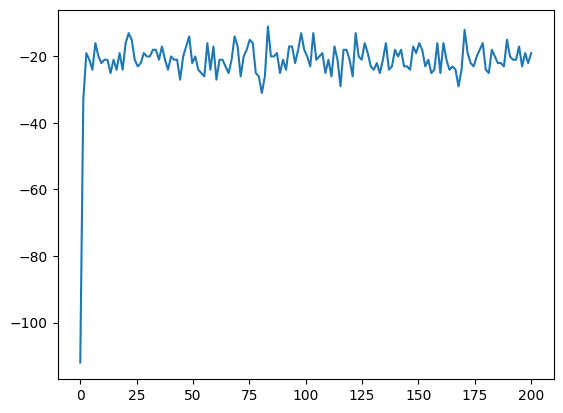

In [217]:
ep = np.linspace(0,200,150)
plt.plot(ep,np.array([stats[1]]).reshape(150))


C:\Users\mfb22\AppData\Local\Temp\ipykernel_8020\4107277353.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).float()


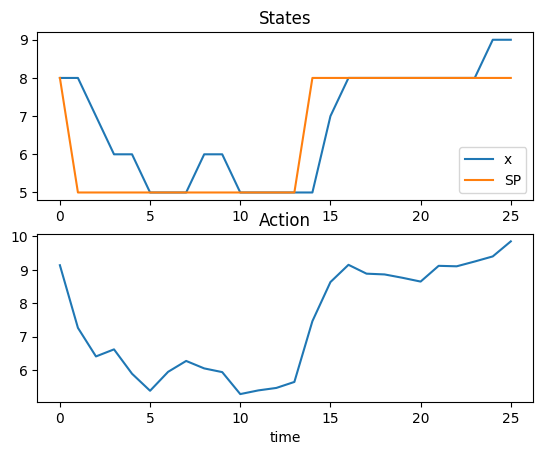

In [218]:
states, rewards, actions = rollout(agent, env)

t = np.linspace(0,env_params['tsim'],env_params['N'])

plt.subplot(211)
plt.title('States')
plt.plot(t,np.array([states])[0],label =['x','SP'])
plt.legend()

plt.subplot(212)
plt.title('Action')
plt.plot(t,np.array([actions])[0])
plt.xlabel('time')
plt.show()